In [5]:
!pip uninstall -y yfinance

Found existing installation: yfinance 0.2.57
Uninstalling yfinance-0.2.57:
  Successfully uninstalled yfinance-0.2.57


In [6]:
!pip install yfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 33.5 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf  # To fetch stock data

In [8]:
# Define stock ticker and date range
stock_ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2025-04-16"

# Download data
df = yf.download(stock_ticker, start=start_date, end=end_date)

# Display first few rows
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.320431,24.789800,23.879980,24.778677,212818400
2015-01-05,23.635286,24.169166,23.448429,24.089084,257142000
2015-01-06,23.637510,23.897776,23.274916,23.699796,263188400
2015-01-07,23.968958,24.069060,23.735385,23.846610,160423600
2015-01-08,24.889900,24.947738,24.180285,24.298185,237458000


In [9]:
# Use only 'Close' price for prediction
data = df['Close'].values

# Normalize data for better performance
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

# Create sequences (X: previous 60 days, Y: next day)
def create_sequences(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X, Y = create_sequences(data_scaled, time_step)

# Reshape X for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

In [10]:
# Define LSTM model
model = Sequential([
    LSTM(20, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(20, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0338 - val_loss: 0.0022
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0013 - val_loss: 9.7921e-04
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 9.8605e-04 - val_loss: 0.0020
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 9.0094e-04 - val_loss: 0.0043
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 9.8959e-04 - val_loss: 0.0014
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Mean Absolute Error: 4.778516264301044
Root Mean Squared Error: 6.466587364330994


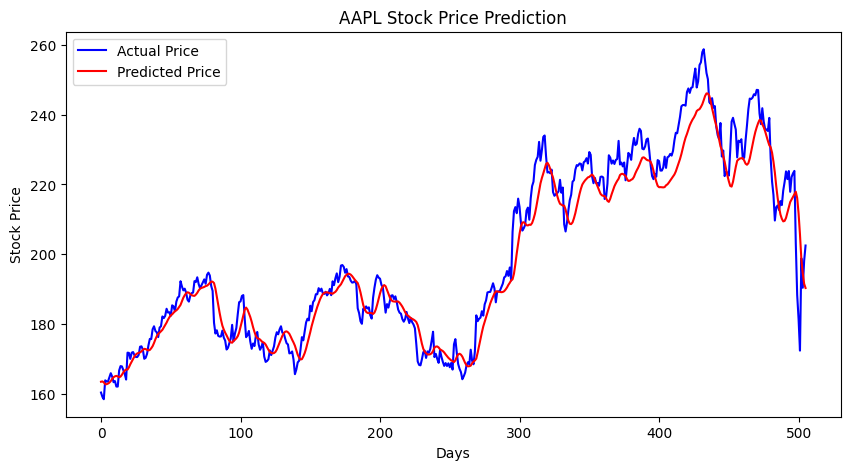

In [11]:
# Predict on test data
Y_pred = model.predict(X_test)

# Convert predictions back to original scale
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))
Y_pred_actual = scaler.inverse_transform(Y_pred)

# Calculate error metrics
mae = mean_absolute_error(Y_test_actual, Y_pred_actual)
rmse = np.sqrt(mean_squared_error(Y_test_actual, Y_pred_actual))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

# Plot actual vs predicted prices
plt.figure(figsize=(10,5))
plt.plot(Y_test_actual, label="Actual Price", color='blue')
plt.plot(Y_pred_actual, label="Predicted Price", color='red')
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.title(f"{stock_ticker} Stock Price Prediction")
plt.show()

In [12]:
last_60_days = data_scaled[-time_step:]
X_future = last_60_days.reshape(1, time_step, 1)

# Predict next day's price
future_price_scaled = model.predict(X_future)
future_price = scaler.inverse_transform(future_price_scaled.reshape(-1, 1))

print(f"Predicted next day closing price: {future_price[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted next day closing price: 191.97
